In [515]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import sys
import pandas as pd

Exercice 1

In [516]:
def generate(X,p):
    n = np.shape(X)[0]
    u = np.random.rand(1)
    order = np.argsort(X)
    X_ord, p_ord = X[order] , p[order]
    inv_cdf = np.cumsum(p_ord)
    inv_cdf = np.insert(inv_cdf,0,0)# Append 0 at the beginning of inverted cdf

    for i in range(n+1):
        if(inv_cdf[i] < u  and u < inv_cdf[i+1]):
            v = X_ord[i]
    return v



In [517]:
def generate_samples(X,p,n_samples):
    samples = []
    for i in range(n_samples):
        g = generate(X,p)
        samples.append(g)
    return samples

In [518]:
X = np.array(range(100))
p = st.binom.pmf(range(100),100,0.6)

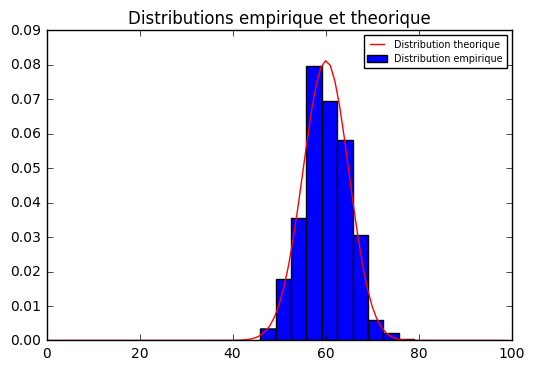

In [519]:
samples = generate_samples(X,p,1000)
plt.hist(samples, normed = 1,label = 'Distribution empirique')
real_weights = st.binom.pmf(range(100),100,0.6)
plt.plot(range(np.shape(X)[0]),real_weights,'r',label = 'Distribution theorique')
plt.legend(fontsize = 'x-small')
plt.title('Distributions empirique et theorique')
plt.show()



La distribution empirique se rapproche de la distribution théorique(ici binomiale de paramètre 0.6) à mesure qu'on augmente le nombre d'échantillons.


Exercice 2



1. Les paramètres du modèle sont:

-Les paramètres de la distribution de $Z_i$ : $(\alpha_1,...,\alpha_K)$.

-Les paramètres $(\mu_j,\Sigma_j)$ de la distribution $\mathcal{N}(\mu_j,\Sigma_j)$ de $X_i$ sachant $Z_i= j$

2.

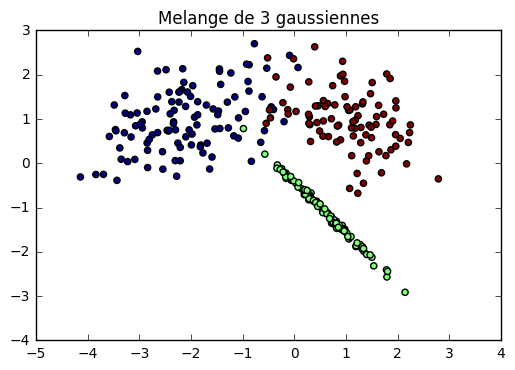

In [520]:
def generate_data(n_samples,mus,sigmas):
    # Number of mixtures
    n_mixtures = np.shape(mus)[0]
    # Initialize samples with zeros
    samples = np.zeros((n_samples,2))
    labels = np.zeros(n_samples)
    # For each sample choose its class randomly
    for i in range(n_samples):
        label = np.random.randint(n_mixtures)
        labels[i] = label
        samples[i] = np.random.multivariate_normal(mus[label],sigmas[label])
        
    
    return labels,samples


        

# Generate a mixture of 3 gaussian 
mus = [[-2,1],[0.5,-1],[1,1]]
sigmas = []
for i in range(3):
    A = np.random.rand(2,2)
    U,s,V = np.linalg.svd(np.dot(A,A.T))
    
    s =  np.diag(np.random.rand(2))
    
    sigmas += [np.dot(np.dot(U,s),V)]
       
labels, samples = generate_data(300,mus,sigmas)
plt.scatter(samples[:,0],samples[:,1],c = labels)
plt.title("Melange de 3 gaussiennes")
plt.show()

3.

L'algorithme EM dans ce cas est le suivant:

-Initialiser $\theta_0$, puis répéter l'étape suivante:

-Etape E : $ \forall i = 1, ..., n ,\forall j = 1,...,K,$
$$q_{t+i}(j) = p_{\theta_t}(z = j|x_i) = \frac{\pi_j \mathcal{N}(\mu_j,\Sigma_j )}{\displaystyle{\sum_{j' = 1}^{K} {\pi_j' \mathcal{N}(\mu_j',\Sigma_j' )}}} \triangleq \tau_i^j $$

-Etape M :
Trouver $\pi_j$, $\mu$ and $\sigma$ qui maximisent

$$
\sum_{i = 1}^n{\sum_{j = 1}^K{\tau_i^j log(\pi_j)}} +\sum_{i = 1}^n{\sum_{j = 1}^K{\tau_i^j ( log( \frac{1}{(2\pi)^{ \frac{p}{2} }} ) + log(\frac{1}{(\sigma^2)^{p/2}}) - \frac{1}{2} (x_i-\mu_j)^T\Sigma^{-1}(x_i-\mu_j) ) }}
$$
où $p$ est la dimension des observations

Par annulation des gradients on obtient:

$$\mu_{j,t+1} = \displaystyle{\frac{\sum_i{\tau_i^j x_i}}{\sum_i{\tau_i^j}}}$$

$$\sigma_{j,t+1} = \displaystyle{\frac{\sum_i{\tau_i^j (x_i - \mu_{j,t+1})(x_i - \mu_{j,t+1})^T}}{ \sum_i{\tau_i^j}}}$$

In [521]:
#Definition of the log-likelihood
def logL(X,q,pi,mu,sigma):
    p = np.shape(X)[1]
    n,K = np.shape(q)
    res = 0
    for i in range(n):
        for j in range(K):
            mean = mu[j]
            S = sigma[j]
            Sinv = np.linalg.pinv(S)
            det = np.linalg.det(S)
            x = X[i]
            res += q[i,j]*(np.log(pi[j]) -np.log(2*np.pi*det)**(p/2) -(1/2)*np.dot((x-mean).T,np.dot(Sinv,x-mean)))

    return res

# Definition of the gaussian density function with non isotropic covariance matrix
def gauss(x,mu,S):
    n = np.shape(x)[0]
    Sinv = np.linalg.pinv(S)
    det = np.linalg.det(S)
    tmp = np.dot((x-mu).T,np.dot(Sinv,x-mu))
    f = (1.0/np.sqrt((2*np.pi*det)**n)) * np.exp(-(1.0/2)*tmp) 
    return f

# Definition of the update function of the weights in the expectation step
def tau(i,j,pi,mu,sigma):
    """
    Computes the weight
    Parameters
    ----------
    i : index of observation
    j : index of  class
    pi : distribution of z
    mu : means of the distributions of x given z
    sigma : covariance matrices of the distributions of x given z
    
    Returns
    -------
    Value of the weight of th
    """
    K = np.shape(pi)[0] # Number of classes
    num = pi[j]*gauss(X[i],mu[j],sigma[j])
    denom = np.sum([pi[j]*gauss(X[i],mu[j],sigma[j]) for j in range(K)])
    return num/denom

# Definition of the update function of the covariance matrix for the maximization step
def updatesigma(j,q,mu):
    
    res = 0
    for i,elt  in enumerate(q[:,j]):
        tmp1 = np.outer(X[i] - mu[j],X[i] - mu[j])
        res += q[i][j]*tmp1
    res /= np.sum(q[:,j])
    
    return res

def EM(X,K,Niter):
    """
    Parameters
    ----------
        K : number of classes
        Niter : number of iterations
        
    Returns
    ------- 
        mu : Array containing the means of each class
        sigma : Array containing the standard deviations of each class
    """
    
    n,p = np.shape(X)
    #Initialization
    pi0 = np.random.rand(K)
    pi0 /= np.sum(pi0)
    
    i = np.random.randint(n,size = K) # Pick k data points at random to initialize the means of the gaussians
    mu0 = X[i]
    
    sigma0 = np.zeros(shape = (K,p,p))
    
    for j in range(K):
        sigma0[j] = (j+1)*np.identity(p)
    pi = pi0
    mu = mu0
    sigma = sigma0
    q = np.random.rand(n,K)# Matrix of Membership weights
    #EM Loop
    labels = range(K)
    t = 0
    logLH = np.zeros(Niter)
    while (t < Niter):
        # E-step
        for i,x in enumerate(X):
            for j in range(K):
                    q[i][j] = tau(i,j,pi,mu,sigma)
        # M-step
        for j in range(K):
            pi[j] = np.mean(q[:,j])
            mu[j] = np.dot(q[:,j],X)/np.sum(q[:,j])
            sigma[j] = updatesigma(j,q,mu)
            
        # Store log-likelihood
        logLH[t] = logL(X,q,pi,mu,sigma)
        t += 1
    return mu,sigma,logLH



In [522]:
mus = [[-2,1],[0.5,-1],[1,1]]
sigmas = []
for i in range(3):
    A = np.random.rand(2,2)
    U,s,V = np.linalg.svd(np.dot(A,A.T))
    
    s =  np.diag(np.random.rand(2))
    
    sigmas += [np.dot(np.dot(U,s),V)]

labels, samples = generate_data(300,mus,sigmas)

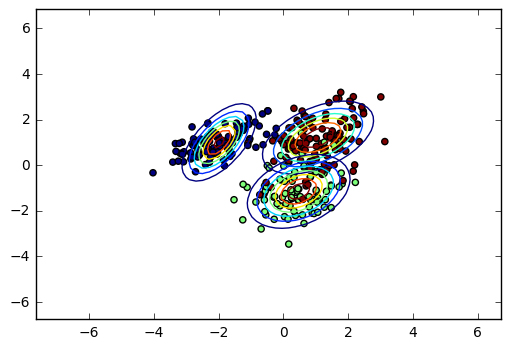

In [523]:
X = samples
mu,sigma,logLH = EM(X,3,40) 
plt.scatter(samples[:,0],samples[:,1],c = labels)
for i,m in enumerate(mu):
    plot_gauss_contour(m,sigma[i],5)
plt.show()

In [524]:
enumerate(mu)

In [525]:
np.shape(sigma)

(3, 2, 2)

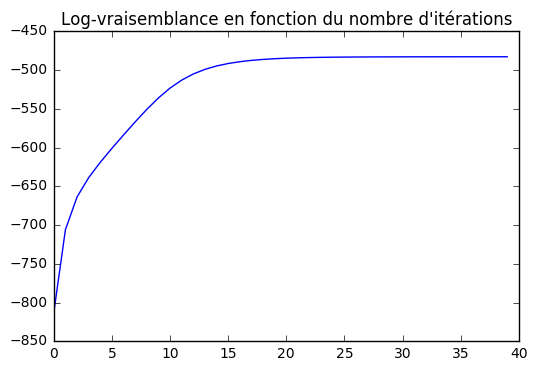

In [526]:
plt.plot(range(40),logLH)
plt.title("Log-vraisemblance en fonction du nombre d'itérations".decode('utf-8'))
plt.show()

In [527]:
print("Moyennes estimées par l'EM:".decode('utf-8'))
print(mu)
print("Moyennes utilisées pour la génération".decode('utf-8'))
print(mus)

Moyennes estimées par l'EM:
[[-1.98667962  1.00312116]
 [ 1.06820236  1.21567811]
 [ 0.47093372 -1.14471448]]
Moyennes utilisées pour la génération
[[-2, 1], [0.5, -1], [1, 1]]


In [528]:
print("Covariances estimées par l'EM:".decode('utf-8'))
print(sigma)

Covariances estimées par l'EM:
[[[ 0.7183989   0.30003501]
  [ 0.30003501  0.32570455]]

 [[ 0.65153296  0.33486771]
  [ 0.33486771  0.75427534]]

 [[ 0.63639877  0.21111912]
  [ 0.21111912  0.61111995]]]


In [529]:
print("Covariances utilisées pour la génération:".decode('utf-8'))
print(sigmas[0])
print(sigmas[1])
print(sigmas[2])

Covariances utilisées pour la génération:
[[ 0.69493615  0.3167113 ]
 [ 0.3167113   0.32607523]]
[[ 0.63684336  0.19670594]
 [ 0.19670594  0.8037139 ]]
[[ 0.58327598  0.20229706]
 [ 0.20229706  0.87292585]]


In [530]:
np.shape(xp)

(50, 50, 2)

4 . On voit que pour un échantillon de taille 300 on obtient une estimation convenable des moyennes et des covariances de chaque gaussienne.

5.

In [531]:
data = pd.read_csv('MVA_TP2_Crude-BirthDeath-Rate.csv')

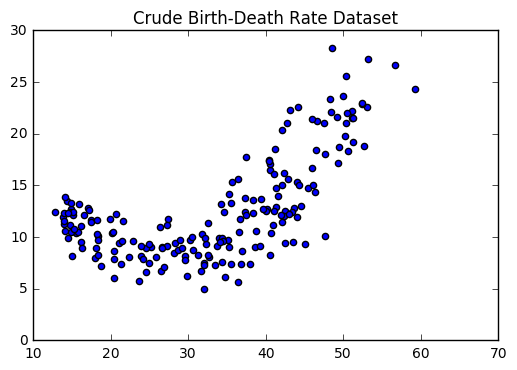

In [532]:
plt.scatter(data['Birth'],data['Death'])
plt.title('Crude Birth-Death Rate Dataset')
plt.show()

6.

In [533]:

def plot_gauss_contour(mu,sigma,size = 20):
    a,b = np.meshgrid(np.linspace(mu[0]-size,mu[0]+size),np.linspace(mu[1]-size,mu[1]+size))
    z = np.zeros((50,50))
    xp = np.array([a,b]).T
    for i in range(50):
        for j in range(50):
            x = xp[i][j]
            z[i][j] = gauss(x,mu,sigma)
    plt.contour(a,b,z)


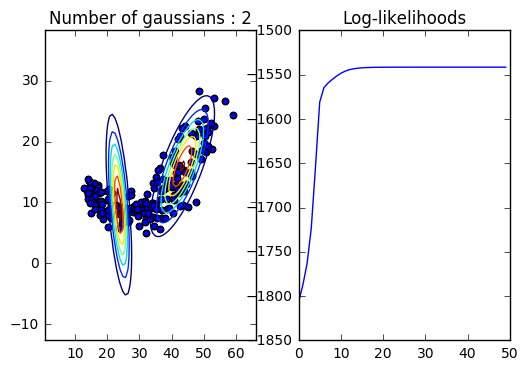

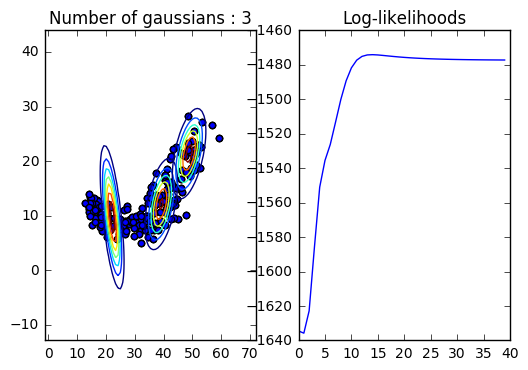

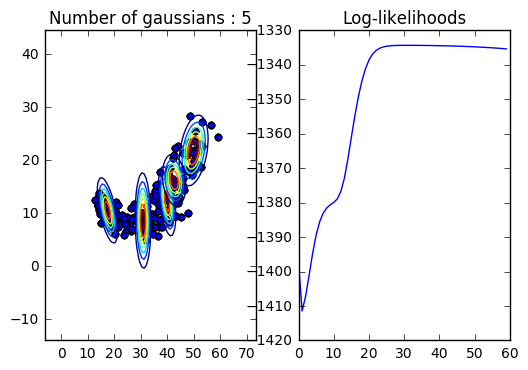

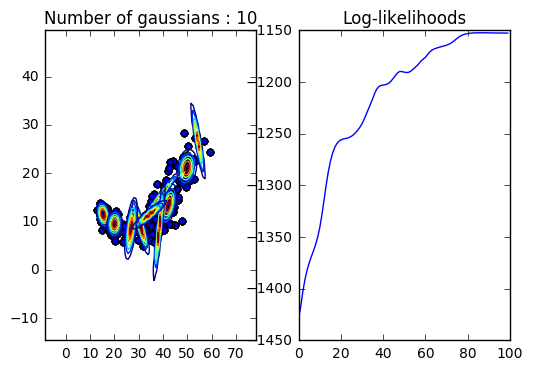

In [534]:
X = data.as_matrix()
Ms = [2,3,5,10]
niters = [50,40,60,100]
for i,m in enumerate(Ms):
    mu,sigma,logLH = EM(X,m,niters[i]) 
    plt.subplot(1,2,1)
    for k in range(m):
        plt.scatter(data['Birth'],data['Death'])
        plot_gauss_contour(mu[k],sigma[k])
    plt.title("Number of gaussians : " + str(m))
    plt.subplot(1,2,2)
    plt.plot(range(niters[i]),logLH)
    plt.title("Log-likelihoods")
    plt.show()
    

In [535]:
from sklearn import mixture

In [536]:
Ms = [1,2,3,5,7,8,10,15]
bics = []
for m in Ms:
    gmm = mixture.GaussianMixture(n_components = m)
    gmm.fit(X)
    bics.append(gmm.bic(X))
    

In [537]:
bics


[2605.0360070585507,
 2431.0114186228602,
 2440.8911341507487,
 2464.3401207497459,
 2518.0665416566321,
 2510.8528416503464,
 2561.8254806301225,
 2687.6988712489251]

Le BIC minimal est atteint pour un nombre de gaussiennes égal à 2. Cela correspond au fait qu'au delà de 2 gaussiennes l'information contenue dans le modèle sera redondante par rapport au modèle à 2 gaussiennes.